# Gradient Boosting

In [1]:
# !pip install imblearn

import os
import pandas as pd
import numpy as np

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE
# Import classifier
from sklearn.linear_model import LogisticRegression 
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Read the data from a parquet file

In [ ]:
df = pd.read_parquet('df_age_18.parquet')

## Display counts and percentages of the target variable

In [ ]:
# Display counts and percentages
value_counts = df['Y'].value_counts()
percentages = df['Y'].value_counts(normalize=True) * 100

result_df = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})
print(result_df)

## Drop unnecessary columns from the dataframe


In [ ]:
df.drop(columns=['#','EBANK_FIRST_OPEN_DATE','CIF_OPEN_DATE',
 'MB2_FIRST_OPEN_DATE',
 'SYM_RUN_DATE'],inplace=True)

## Check for missing values and fill them with 0


In [ ]:
df.isnull().sum()

In [ ]:
df.fillna(0,inplace=True)

In [ ]:
df.isnull().sum()

## Select only numerical features for correlation analysis


In [ ]:
df_corr = df[df.select_dtypes(include='number').columns.tolist()]

## Function to select highly correlated features


In [ ]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

## Find highly correlated features and drop them from the dataframe


In [ ]:
corr_features = correlation(df_corr, 0.7)
len(set(corr_features))

In [ ]:
corr_features

In [ ]:
df_filtered = df.drop(corr_features,axis=1)

In [ ]:
df_filtered.to_parquet('df_filtered_corr.parquet')

In [ ]:
df_filtered = pd.read_parquet('df_filtered_corr.parquet')

## Separate the dataframe into input features (X) and target variable (y)


In [ ]:
#Separate dataframe into separate object

# Object for target variable
y = df_filtered.Y

# object for input features
X = df_filtered.drop(['CLIENT_NO','Y'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)

In [ ]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

In [ ]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

## Split the data into train and test sets


In [ ]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state,
                                                    stratify=df_filtered.Y)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

In [ ]:
X_train.info()

## Get the numerical and categorical columns for preprocessing


In [ ]:
num_features = []

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)

In [ ]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features)

## Define the column transformer for preprocessing


In [ ]:
# Define column transformer
# Need to be numeric not string to specify columns name 
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

In [ ]:
# Fit preprocessing pipeline on train data
preprocess.fit(X_train)

In [ ]:
# Apply preprocessing pipeline to train and test data
X_train_preprocessed = preprocess.transform(X_train)
X_test_preprocessed = preprocess.transform(X_test)

In [ ]:
# Define SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=random_state)

In [ ]:
# Fit SMOTE on preprocessed train data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

In [ ]:
len(X_train_resampled)

In [ ]:
160645

In [ ]:
pd.DataFrame(X_train_resampled).to_parquet("X_train_resampled.parquet",index=False)
pd.DataFrame(y_train_resampled).to_parquet("y_train_resampled.parquet",index=False)
pd.DataFrame(X_test_preprocessed).to_parquet("X_test_preprocessed.parquet",index=False)
pd.DataFrame(y_test).to_parquet("y_test.parquet",index=False)

## Define the Gradient Boosting classifier and set hyperparameters for grid search


In [2]:
X_train_resampled = pd.read_parquet('X_train_resampled.parquet')
y_train_resampled = pd.read_parquet('y_train_resampled.parquet')
X_test_preprocessed = pd.read_parquet('X_test_preprocessed.parquet')
y_test = pd.read_parquet('y_test.parquet')

In [3]:
# Define KNN classifier
gb = GradientBoostingClassifier(random_state=10)

## Fit the model on the resampled train data using grid search cross-validation


In [5]:
param_grid = {
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,6]
}
CV_rfc = GridSearchCV(estimator=gb, param_grid=param_grid, cv= 5, scoring = 'accuracy', verbose = 3)
CV_rfc.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....max_depth=4, max_features=sqrt;, score=0.940 total time= 1.9min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ....max_depth=4, max_features=sqrt;, score=0.940 total time= 1.6min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....max_depth=4, max_features=sqrt;, score=0.942 total time= 1.6min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ....max_depth=4, max_features=sqrt;, score=0.945 total time= 1.6min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....max_depth=4, max_features=sqrt;, score=0.947 total time= 1.9min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....max_depth=4, max_features=log2;, score=0.940 total time= 1.2min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ....max_depth=4, max_features=log2;, score=0.939 total time= 1.2min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....max_depth=4, max_features=log2;, score=0.941 total time= 1.5min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ....max_depth=4, max_features=log2;, score=0.945 total time= 2.0min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....max_depth=4, max_features=log2;, score=0.946 total time= 1.2min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....max_depth=6, max_features=sqrt;, score=0.941 total time= 2.4min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ....max_depth=6, max_features=sqrt;, score=0.941 total time= 2.3min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....max_depth=6, max_features=sqrt;, score=0.944 total time= 2.3min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ....max_depth=6, max_features=sqrt;, score=0.950 total time= 2.3min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....max_depth=6, max_features=sqrt;, score=0.950 total time= 2.2min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....max_depth=6, max_features=log2;, score=0.941 total time= 1.8min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ....max_depth=6, max_features=log2;, score=0.941 total time= 1.8min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....max_depth=6, max_features=log2;, score=0.943 total time= 1.7min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ....max_depth=6, max_features=log2;, score=0.948 total time= 1.7min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....max_depth=6, max_features=log2;, score=0.948 total time= 1.8min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=10),
             param_grid={'max_depth': [4, 6], 'max_features': ['sqrt', 'log2']},
             scoring='accuracy', verbose=3)

In [8]:
predictions_test = CV_rfc.predict(X_test_preprocessed)
# print(f"First 10 Predictions:   {predictions_test[:10]}")
# print(f"First 10 Actual labels: {y_test[:10].tolist()}")

In [9]:
predictions_train = CV_rfc.predict(X_train_resampled)
# print(f"First 10 Predictions:   {predictions_train[:10]}")
# print(f"First 10 Actual labels: {y_train_resampled[:10].tolist()}")

In [10]:
print(classification_report(y_test, predictions_test))


              precision    recall  f1-score   support

           0       0.92      0.93      0.92    183129
           1       0.96      0.95      0.96    344240

    accuracy                           0.95    527369
   macro avg       0.94      0.94      0.94    527369
weighted avg       0.95      0.95      0.95    527369



In [11]:
print(classification_report(y_train_resampled, predictions_train))


              precision    recall  f1-score   support

           0       0.95      0.93      0.94    803226
           1       0.94      0.96      0.95    803226

    accuracy                           0.94   1606452
   macro avg       0.94      0.94      0.94   1606452
weighted avg       0.94      0.94      0.94   1606452



## Print the best hyperparameters found by grid search


In [12]:
CV_rfc.best_params_

{'max_depth': 6, 'max_features': 'sqrt'}

In [19]:
CV_rfc.feature_names_in_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '80', '81', '82', '83', '84'], dtype=object)

In [14]:
import joblib
filename = './Models/Gradient_Boosting.sav'
joblib.dump(CV_rfc, filename)

['./Models/Gradient_Boosting.sav']

In [21]:
X_test_preprocessed.shape

(527369, 85)

## Plot feature importances using Gradient Boosting classifier

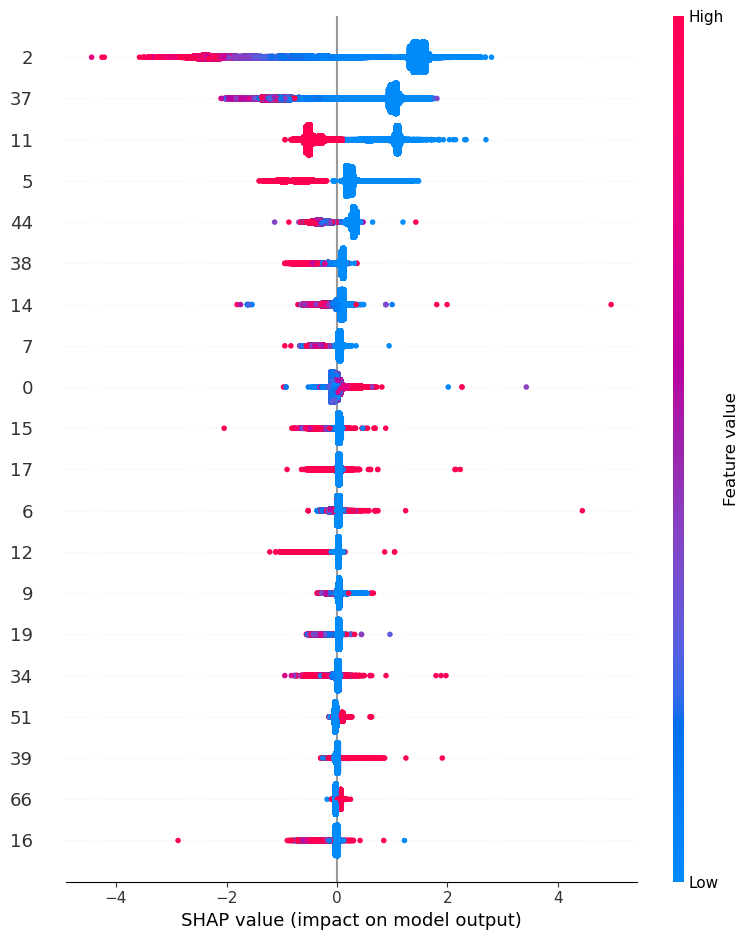

In [17]:
import shap

# Assuming you have already trained your model and obtained predictions
# Let's say your model is stored in the variable 'model' and your data is stored in the variable 'X'

# Create an explainer object
explainer = shap.Explainer(CV_rfc.best_estimator_)

# Calculate SHAP values for your data
shap_values = explainer(X_test_preprocessed)

# Plot the SHAP values
shap.summary_plot(shap_values, X_test_preprocessed)
